In [44]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import time
import math
from numba import jit
import scipy.io

%matplotlib notebook

light="#61b5f4"
light_highlight="#C79999"
mid="#2a86e5"
mid_highlight="#A25050"
dark="#2216c4"
dark_highlight="#7C0000"
green="#00FF00"

## Simulated data for block trial structure

<IPython.core.display.Javascript object>


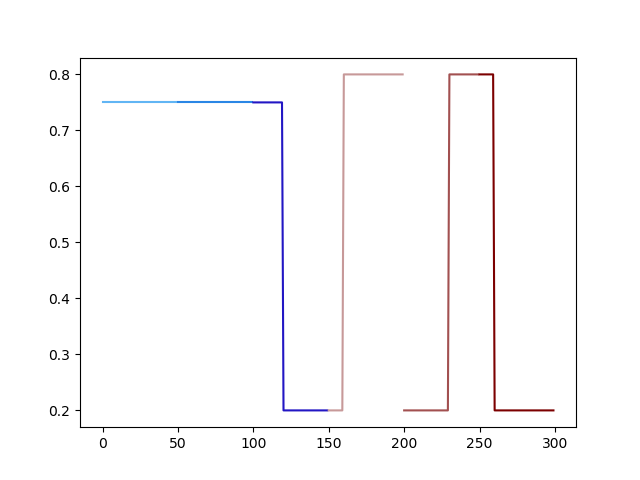

<IPython.core.display.Javascript object>


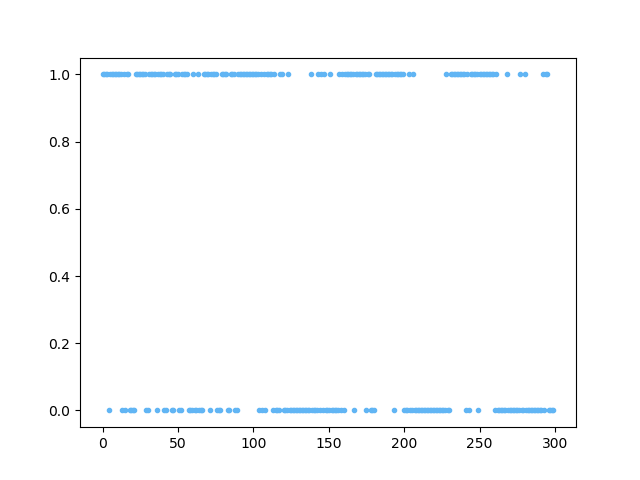

In [45]:
# Generate fake data from the model
# Build the true reward rate
true_prob = [0.75] * 120 + [0.2] * 40 + [0.8] * 40 + [0.2] * 30 + [0.8] * 30 + [0.2] * 40
plt.figure()
plt.plot(true_prob[:50], color=light)
plt.plot(np.arange(50, 100), true_prob[50:100], color=mid)
plt.plot(np.arange(100, 150), true_prob[100:150], color=dark)

plt.plot(np.arange(150, 200), true_prob[150:200], color=light_highlight)
plt.plot(np.arange(200, 250), true_prob[200:250], color=mid_highlight)
plt.plot(np.arange(250, 300), true_prob[250:300], color=dark_highlight)


# Generate data from bernoulli
randvars = np.random.random(len(true_prob))
outcomes = randvars < true_prob
plt.figure()
plt.plot(outcomes, '.', color=light)

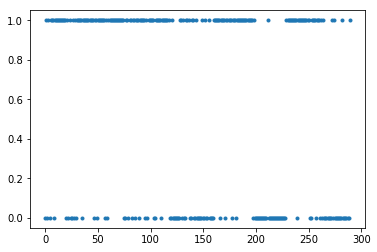

In [3]:
# Load the previously saved .mat file
data = scipy.io.loadmat('outcomes.mat')
outcomes = data['outcomes'][0]
plt.figure()
plt.plot(outcomes, '.')

## Exact inference

In [4]:
# Define some conditionals that will be useful
@jit(nopython=True)
def my_beta(x, a, b):
    #print('beta', x, a, b)
    constant = math.gamma(a + b) / math.gamma(a) / math.gamma(b)
    return constant * x**(a - 1) * (1 - x)**(b - 1)
@jit(nopython=True)
def my_normal(x, mu, sigma):
    constant = 1 / np.sqrt(2 * np.pi * sigma**2)
    return np.exp(-(x - mu)**2 / 2 / sigma**2) * constant

# Test these
xvals = np.linspace(0, 1, 1000)
my_result = my_beta(xvals, 3, 4)
sts_result = sts.beta.pdf(xvals, 3, 4)

my_normal = my_normal(xvals, 3, 4)
sts_normal = sts.norm.pdf(xvals, 3, 4)


print('Beta test error: ', np.sum((sts_result - my_result)**2))
print('Normal test error: ', np.sum((sts_normal - my_normal)**2))

Beta test error:  2.6138349401201225e-28
Normal test error:  4.7955655615242173e-32


In [56]:
#@jit(nopython=True)
def pr_next(rnext, rprev, v, method):
    '''Find p(r_{i+1} = rnext | r_i = rprev, v)'''
    if method=='beta':
        # Take care of boundaries:
        rval = np.maximum(rnext, 1e-10)
        rval = np.minimum(rval, (1 - 1e-10))

        s = rprev * np.exp(-v)
        n = (1 - rprev) * np.exp(-v)

        s = np.maximum(s, 1e-10)
        n = np.maximum(n, 1e-10)

        # Math range error if use my_beta
        #print(s, n)
        return sts.beta.pdf(rval, s, n)
    elif method=='gaussian':
        return pr_next_gaussian(rnext, rprev, v)
    #elif method=='step':
        
    else:
        raise ValueError('Invalid method')
    

@jit(nopython=True)
def pr_next_gaussian(rnext, rprev, v):
    '''Find p(r_{i+1} = rnext | r_i = rprev, v),
    with a Gaussian distribution'''
    #print('here')
    V = np.exp(v)
    mu = rprev
    sigma = V
    x = rnext
    constant = 1 / np.sqrt(2 * np.pi * sigma**2)
    #normalizing = sts.norm.cdf(1, mu, sigma) - sts.norm.cdf(0, mu, sigma)
    
    result = np.exp(-(x - mu)**2 / 2 / sigma**2) * constant 
    return result
    
@jit(nopython=True)
def pv_next(vnext, vprev, k):
    '''Find p(v_{i+1} = vnext | v_i = vprev, k)'''
    K = np.exp(k)
    mu = vprev
    sigma = K
    x = vnext
    constant = 1 / np.sqrt(2 * np.pi * sigma**2)
    return np.exp(-(x - mu)**2 / 2 / sigma**2) * constant
    #return my_normal(vnext, vprev, K) #sts.norm.pdf(vnext, vprev, K)

@jit(nopython=True)
def py_given_r(y, r):
    '''p(y = y| r), which is bernoulli'''
    assert(r <= 1 and r >= 0)
    assert(y == 1 or y == 0)
    if y == 1:
        return r
    else:
        return 1 - r

In [59]:
def find_posterior_t_vec_fast(nr, nv, nk, y, prev_res, method):
    '''Inputs:
    - nr, nv, nk: indices of the r, v, k desired
    - prev_res: Nr x Nv x Nk array encoding posterior at time t - 1
    - Returns the posterior at time t corresponding to nr, nv, nk'''
    r = rvals[nr]
    k = kvals[nk]
    v = vvals[nv]
    
    p_yr = py_given_r(y, r)
    # Find the p(v_i+1 | v_i, k) arr
    p_rv = pr_next(r, rvals, v, method=method)
    
    # Normalize
    p_rv = p_rv / (np.sum(p_rv) * dr)
    P_rv = np.tile(p_rv, (len(vvals), 1)).T
    
    # Find posterior_prev matrix
    posterior_prev = prev_res[:,:,nk]
    
    # Find the p(r_i+1 | r_i, k) arr
    p_vk = pv_next(v, vvals, k)
    
    # Normalize
    p_vk = p_vk / (np.sum(p_vk) * dv)
    P_vk = np.tile(p_vk, (len(rvals), 1))
    
    # Integrate over the grid
    integral = np.sum(P_rv * P_vk * posterior_prev * dv * dr)
    return integral * p_yr

In [60]:
def find_posterior_t_arr(y, prev_res, method='beta'):
    '''Inputs:
    - prev_res: Nr x Nv x Nk array encoding posterior at time t - 1
    - Returns the Nr x Nv x Nk array encoding posterior at time t'''
    result = np.zeros_like(prev_res)
    for nr in range(len(rvals)):
        for nv in range(len(vvals)):
            for nk in range(len(kvals)):
                result[nr, nv, nk] = find_posterior_t_vec_fast(nr, nv, nk, y, prev_res, method=method)
    # Normalize
    result = result / np.sum(result)
    return result

## Simple model with r and v ony

In [9]:
def find_posterior_tv(nr, nv, y, prev_res, method):
    '''Inputs:
    - nr, nv, nk: indices of the r, v, k desired
    - prev_res: Nr x Nv x Nk array encoding posterior at time t - 1
    - Returns the posterior at time t corresponding to nr, nv, nk'''
    r = rvals[nr]
    v = vvals[nv]
    
    p_yr = py_given_r(y, r)
    #print('r = ', r, 'y = ', y, 'p_yr = ', p_yr)
    # Find the p(v_i+1 | v_i, k) arr
    p_rv = pr_next(r, rvals, v, method=method)
    
    # Normalize p_rv
    p_rv = p_rv / (np.sum(p_rv) * dr)
    #print('r = ', r, 'v = ', v, 'p_rv = ', p_rv)
    
    # Find posterior_prev matrix
    posterior_prev = prev_res[:,nv]
    #print('posterior_prev = ', posterior_prev)
     
    # Integrate over the grid
    integral = np.sum(p_rv * posterior_prev * dv * dr)
    return integral * p_yr

def find_posterior_tv_arr(y, prev_res, method='beta'):
    result = np.zeros_like(prev_res)
    for nr in range(len(rvals)):
        for nv in range(len(vvals)):
            result[nr, nv] = find_posterior_tv(nr, nv, y, prev_res, method=method)
            
    # Normalize
    result = result / np.sum(result)
    return result

In [57]:
# For t-v only model
# Set up a grid of r, v
rvals = np.linspace(0, 1, 50)
vvals = np.linspace(-9, 5, 150)
dv = vvals[1] - vvals[0]
dr = rvals[1] - rvals[0]
#outcomes = np.array([1, 0, 1])

# Build the 'prior' matrix nr x nv x nk
prior = np.ones((len(rvals), len(vvals)))

for nr, rval in enumerate(rvals):
    for nv, vval in enumerate(vvals):
        vprob = sts.norm.pdf(vval, -3.5, 1)
        prior[nr, nv] = vprob

# Normalize
prior /= np.sum(prior)

begin = time.time()
#Initialize array for storage
result_final = np.ones((len(rvals), len(vvals), len(outcomes)))
result_final = result_final / np.sum(result_final[:,:,0])
#result_final[:,:,0] = prior


nsimulate = len(outcomes) - 1

# Perform the iterative updates
for t in range(nsimulate):
    print(t)
    result = find_posterior_tv_arr(outcomes[t], result_final[:,:,t], method='gaussian')
    result_final[:,:,t+1] = result
end = time.time()
print('Elapsed time is ', end - begin)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [53]:
rprobs = []
vprobs = []
rstd = []
vstd = []

for t in range(nsimulate):
    endres = result_final[:,:,t]
    # Marginalize out v and k
    r_prob = np.sum(endres, axis=1)
    v_prob = np.sum(endres, axis=0)
    
    # Expectations
    expR = np.sum(r_prob / np.sum(r_prob) * rvals)
    expV = np.sum(v_prob / np.sum(v_prob) * vvals)
    
    # Standard deviations
    expR2 = np.sum(r_prob / np.sum(r_prob) * (rvals**2))
    stdR2 = np.sqrt(expR2 - expR**2)
    
    expV2 = np.sum(v_prob / np.sum(v_prob) * (vvals**2))
    stdV2 = np.sqrt(expV2 - expV**2)
    
    rprobs.append(expR)
    vprobs.append(expV)
    rstd.append(stdR2)
    vstd.append(stdV2)

<IPython.core.display.Javascript object>


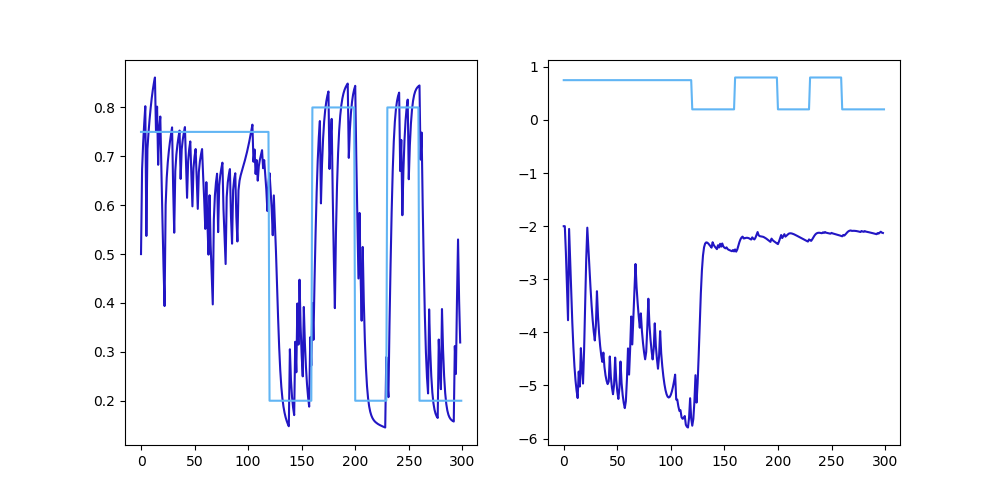

In [58]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(rprobs, color=dark)
plt.plot(true_prob, light)

plt.subplot(122)
plt.plot(vprobs, color=dark)
plt.plot(true_prob, color=light)

<IPython.core.display.Javascript object>


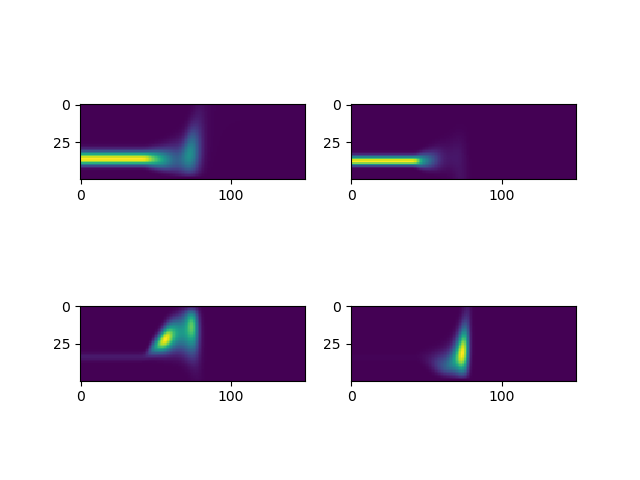

In [49]:
plt.figure()
plt.subplot(221)
plt.imshow(result_final[:,:,50])
plt.subplot(222)
plt.imshow(result_final[:,:,100])
plt.subplot(223)
plt.imshow(result_final[:,:,150])
plt.subplot(224)
plt.imshow(result_final[:,:,200])

## r,v,k full model

In [10]:
# Set up a grid of r, v, k
rvals = np.linspace(0, 1, 20)
vvals = np.linspace(-5, 5, 20)
kvals = np.linspace(-5, 5, 20)
# vrange = (-4.5, -4), krange = (-5, -3) for beta inference


dv = vvals[1] - vvals[0]
dr = rvals[1] - rvals[0]
#outcomes = ysim

# Build the 'prior' matrix nr x nv x nk
prior = np.ones((len(rvals), len(vvals), len(kvals)))

for nr, rval in enumerate(rvals):
    for nv, vval in enumerate(vvals):
        for nk, kval in enumerate(kvals):
            vprob = sts.norm.pdf(vval, -3.5, 1)
            kprob = sts.norm.pdf(kval, -3.5, 1)
            prior[nr, nv, nk] = vprob * kprob

# Normalize
prior /= np.sum(prior)


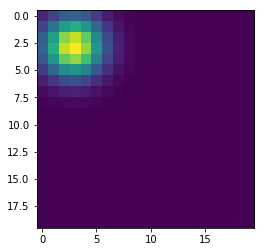

In [12]:
plt.imshow(prior[5,:,:])

In [70]:
# Set up a grid of r, v, k
rvals = np.linspace(0, 1, 20)
vvals = np.linspace(-9, 5, 30)
kvals = np.linspace(-9, 5, 30)

dv = vvals[1] - vvals[0]
dr = rvals[1] - rvals[0]

begin = time.time()
#Initialize array for storage
result_final = np.ones((len(rvals), len(vvals), len(kvals), len(outcomes)))
#result_final[:,:,:,0] = prior


nsimulate = len(outcomes) - 1

# Perform the iterative updates
for t in range(nsimulate):
    print(t)
    result = find_posterior_t_arr(outcomes[t], result_final[:,:,:,t], method='gaussian')
    result_final[:,:,:,t+1] = result
end = time.time()
print('Elapsed time is ', end - begin)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## Evolution of the parameters

In [71]:
rprobs = []
vprobs = []
kprobs = []
rstd = []
vstd = []

for t in range(nsimulate):
    endres = result_final[:,:,:,t]
    # Marginalize out v and k
    r_prob = np.sum(endres, axis=(1,2))
    v_prob = np.sum(endres, axis=(0,2))
    k_prob = np.sum(endres, axis=(0,1))
    
    # Expectations
    expR = np.sum(r_prob / np.sum(r_prob) * rvals)
    expV = np.sum(v_prob / np.sum(v_prob) * vvals)
    expK = np.sum(k_prob / np.sum(k_prob) * kvals)
    
    # Standard deviations
    expR2 = np.sum(r_prob / np.sum(r_prob) * (rvals**2))
    stdR2 = np.sqrt(expR2 - expR**2)
    
    expV2 = np.sum(v_prob / np.sum(v_prob) * (vvals**2))
    stdV2 = np.sqrt(expV2 - expV**2)
    
    rprobs.append(expR)
    vprobs.append(expV)
    kprobs.append(expK)
    rstd.append(stdR2)
    vstd.append(stdV2)
    

<IPython.core.display.Javascript object>


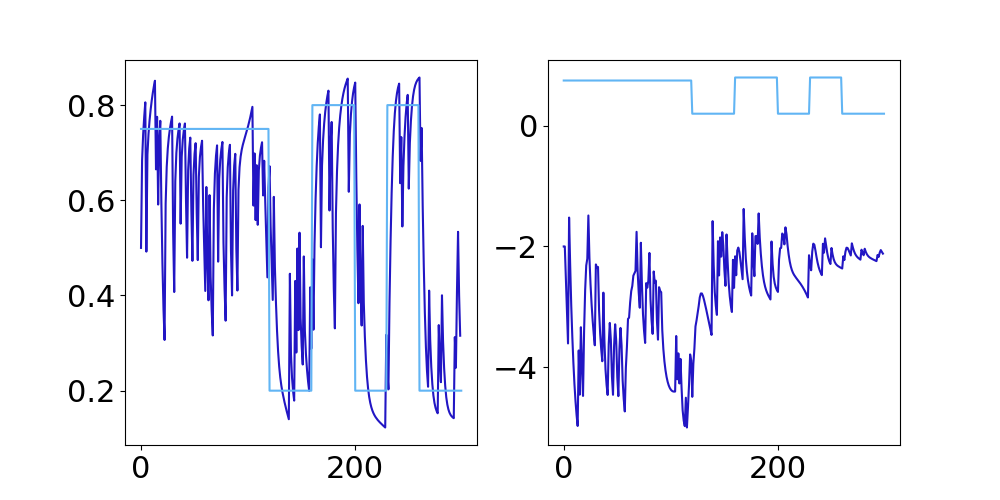

In [73]:
font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(rprobs, color=dark)
plt.plot(true_prob, light)

plt.subplot(122)
plt.plot(vprobs, color=dark)
plt.plot(true_prob, color=light)

In [93]:
# Marginalize over k
marg_k = np.sum(result_final, axis=2)

# Marginalize over r
marg_r = np.sum(result_final, axis=0)

<IPython.core.display.Javascript object>


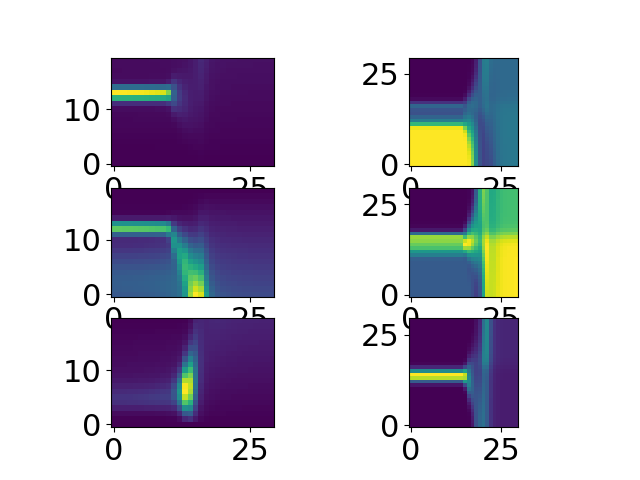

In [96]:
plt.figure()
plt.subplot(321)
plt.imshow(marg_k[:,:,120])
plt.gca().invert_yaxis()

plt.subplot(323)
plt.imshow(marg_k[:,:,127])
plt.gca().invert_yaxis()

plt.subplot(325)
plt.imshow(marg_k[:,:,160])
plt.gca().invert_yaxis()
#plt.subplot(224)
#plt.imshow(result_final[:,:,0,200])

plt.subplot(322)
plt.imshow(marg_r[:,:,120])
plt.gca().invert_yaxis()

plt.subplot(324)
plt.imshow(marg_r[:,:,127])
plt.gca().invert_yaxis()

plt.subplot(326)
plt.imshow(marg_r[:,:,160])
plt.gca().invert_yaxis()

<IPython.core.display.Javascript object>


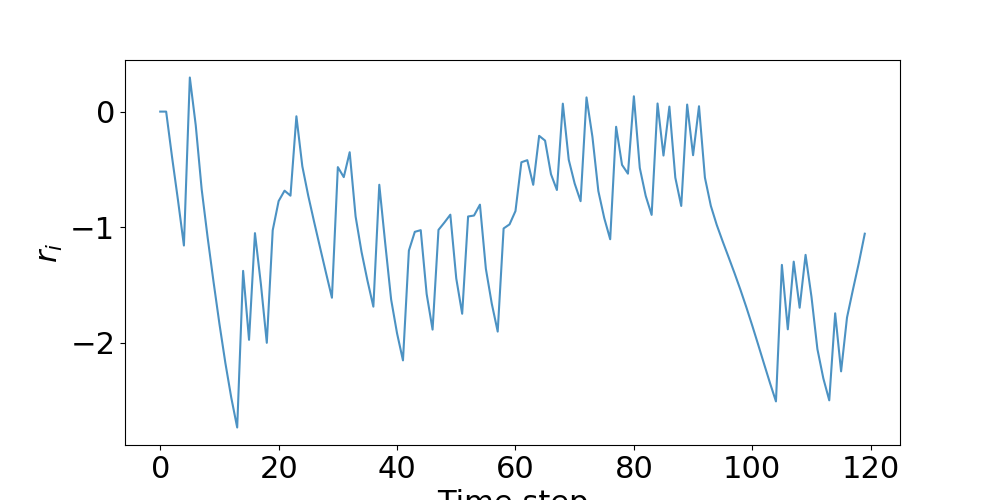

Text(0.5, 0, 'Time step')

In [65]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(vprobs)), vprobs, label='Estimated reward', alpha=0.8)
#plt.plot(np.array(true_prob)[:nsimulate] * 0.1 - 4.3, 'r--', label='True reward')
plt.ylabel(r'$r_i$')
plt.xlabel('Time step')
#plt.legend(loc='upper right')
#plt.savefig('behrens.pdf')

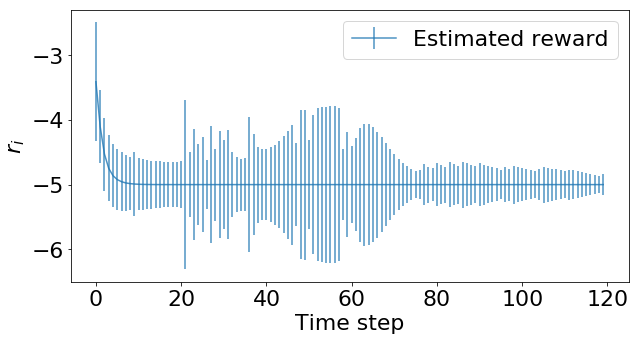

In [17]:
plt.figure(figsize=(10,5))
plt.errorbar(np.arange(len(kprobs)), kprobs, vstd, label='Estimated reward', alpha=0.8)
#plt.plot(k, 'r--', label='True reward')
plt.ylabel(r'$r_i$')
plt.xlabel('Time step')
plt.legend(loc='upper right')
#plt.savefig('behrens.pdf')

In [109]:
kprobs

[0.26848010653502125,
 0.19686935566242147,
 0.14925062570597974,
 0.11612646739401566,
 0.09191558115055437,
 0.07369807347146946,
 0.05965289080762107,
 0.04869612546531204,
 0.03997027327094669,
 0.032957276122895125,
 0.027271274601920515,
 0.022605916747145738,
 0.018779203017136065,
 0.015626233261814827,
 0.013036487800241846,
 0.010886784089260174,
 0.009091656830460237,
 0.007598162436929632,
 0.006360980443758068,
 0.005326830634964753,
 0.004463012166075821,
 0.0037406429890586112,
 0.0031328179553133297,
 0.0026241340071485562,
 0.0022008328789623194,
 0.001845700076433543,
 0.0015465932915252204,
 0.0012960539587708007,
 0.0010873928780510663,
 0.0009122031197516276,
 0.0007645592952418657,
 0.0006416013350915387,
 0.000537764917131449,
 0.0004512875245238451,
 0.0003782604033355842,
 0.00031705733835006025,
 0.00026573921410157265,
 0.00022271763206742316,
 0.00018688781424044495,
 0.0001568012327153058,
 0.00013143905196262391,
 0.00011017927730658674,
 9.234937632935836